C:\Users\acer\AppData\Local\Temp\ipykernel_7952\2822753920.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001506.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
C:\Users\acer\AppData\Local\Temp\ipykernel_7952\2822753920.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32499.999999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $2,631,900.18
Total Return: 163.19%
Max Portfolio Value: $3,151,933.11
Min Portfolio Value: $966,500.32
Max Long Position: 53.4082
Max Short Position: -6.2500
Final BTC Position: 26.0409

Risk Metrics:
Annualized Return: 20.28%
Annualized Volatility: 43.84%
Sharpe Ratio: 0.42
Maximum Drawdown: -69.00%


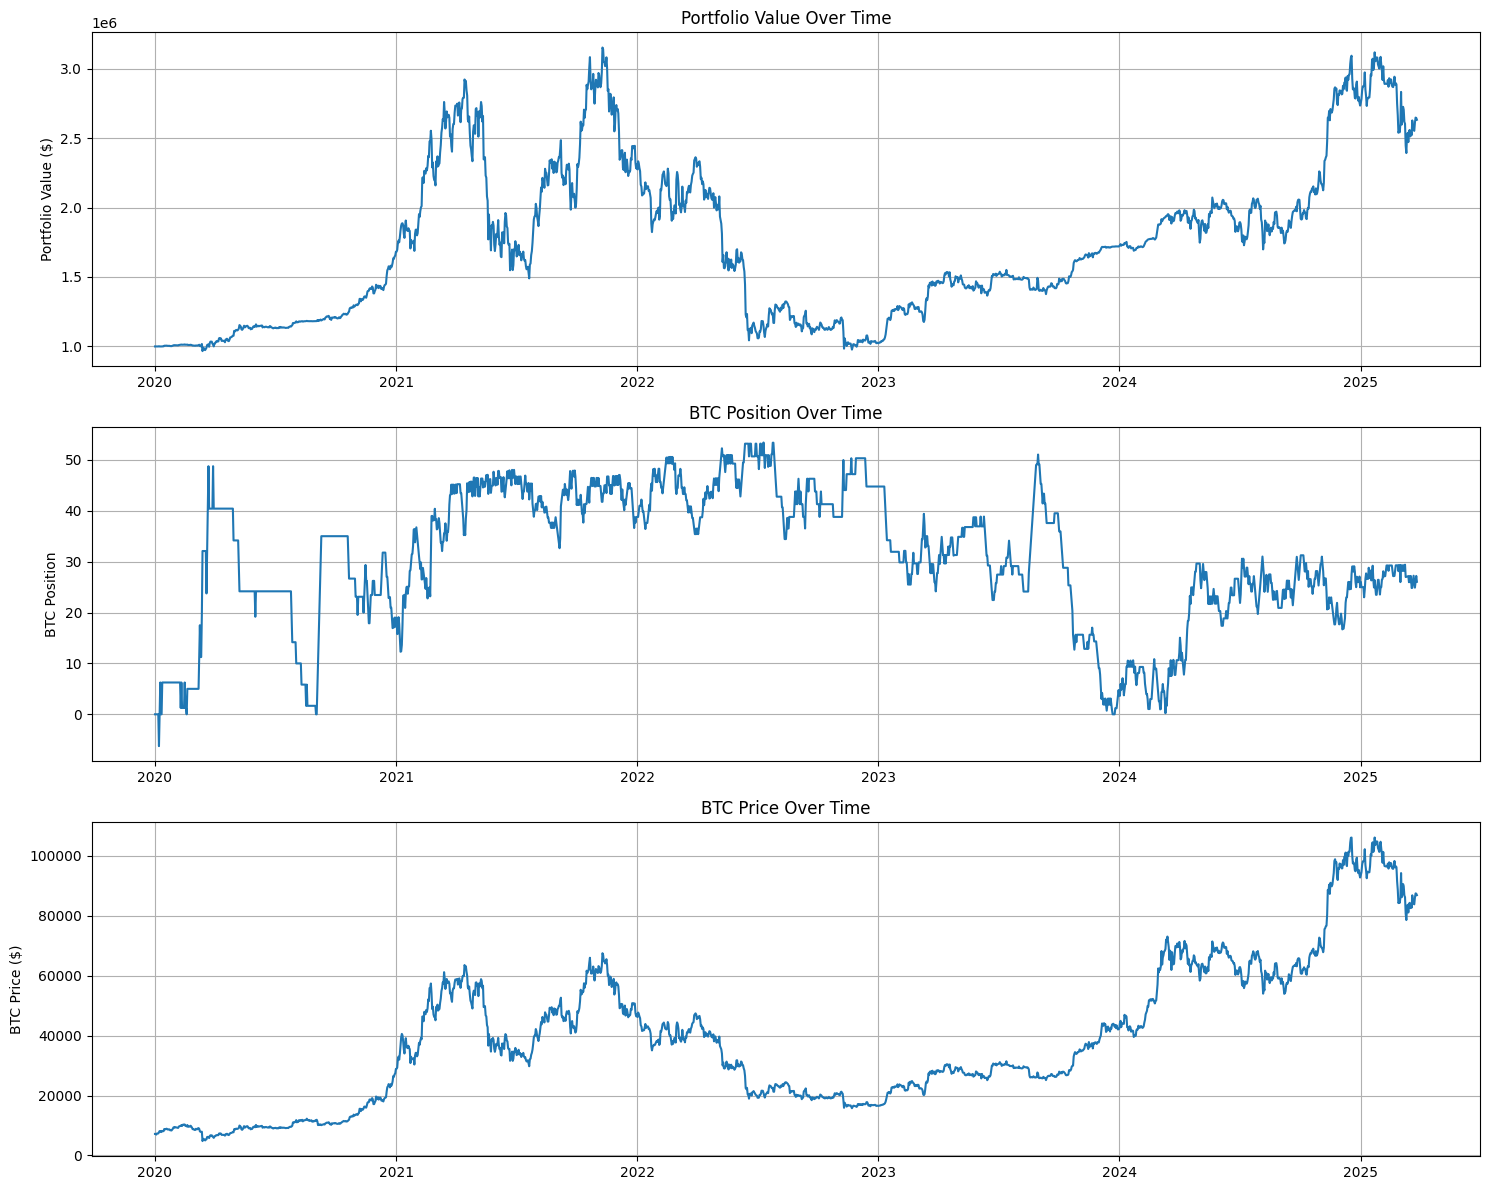


Recent Trades:
1904: Close long at 87000.0: -1.1494252873563218 BTC
1905: Open long at 84000.0: +1.1904761904761905 BTC
1905: Close long at 87000.0: -1.1494252873563218 BTC
1906: Open long at 84000.0: +1.1904761904761905 BTC
1907: Open long at 84000.0: +1.1904761904761905 BTC
1908: Close long at 84000.0: -1.1904761904761905 BTC
1909: Close long at 87000.0: -1.1494252873563218 BTC
1910: Open long at 87000.0: +1.1494252873563218 BTC
1911: Open long at 87000.0: +1.1494252873563218 BTC
1912: Close long at 87000.0: -1.1494252873563218 BTC


In [1]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}
# indexlist = ['BTC', 'ETH', 'XRP', 'SOL', 'ADA', 'DOGE', 'TRX', 'SHIB','DOT','PEPE','AVAX', 'TON', 'SUI', 'LINK','XLM',]
# indexlist = ['BTC', 'ETH', 'XRP', 'SOL', 'ADA', 'DOGE', 'TRX', 'SHIB','DOT','PEPE']
indexlist = ['BTC','ETH','SOL']
timeframe = '1d'
beijing_tz = pytz.timezone('Asia/Shanghai')
beijing_time = datetime(2020, 1, 1, 0, 0, 0)
beijing_time = beijing_tz.localize(beijing_time)
central_tz = pytz.timezone('America/Chicago')
central_time = beijing_time.astimezone(central_tz)
since = int(time.mktime(central_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)
   
indexss = 'BTC'
# indexss = 'SOL'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

## simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth/10/2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth/10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth/10*1.5}
}

# Short grid has double grid size and half position size
short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth/10/2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth/10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth/10*1.5}
}

def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')]

# Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365 ## crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)